In [2]:
import os
import numpy as np
import math
import cv2
import glob
from  matplotlib import pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
print(tf.__version__)
'''
https://www.tensorflow.org/tutorials/load_data/images
從磁碟機讀取 image dataset方法
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

2.3.1


In [182]:
# dataset
train_dir=r'C:\Users\user\chou_paper_data\flower_data\train'  # training data
predict_dir=r'C:\Users\user\chou_paper_data\flower_data\valid'  # testing data
test_dir=r'C:\Users\user\chou_paper_data\flower_data\test'  # test data
batch_size=32
img_size=(227, 227)
freeze_layers_number=0
classes=sorted([o for o in os.listdir(train_dir)])  # 根据文件名分类

import requests
import json
file_location=r'C:\Users\user\chou_paper_data\flower_data\cat_to_name.json'
f=open(file_location)
class_names=json.loads(f.read())
class_names = {int(k):v for k,v in class_names.items()}

nb_train_samples = len(glob.glob(train_dir + '/*/*.*'))  # number of training data
nb_predict_samples = len(glob.glob(predict_dir + '/*/*.*'))  # number of validing data
nb_test_samples = len(glob.glob(test_dir + '/*.*'))  # number of test data
print(nb_train_samples,nb_predict_samples,nb_test_samples,'total=',nb_train_samples+nb_predict_samples+nb_test_samples)

6552 818 819 total= 8189


In [186]:
'''
ref:ImageNet Classification with Deep Convolutional Neural Networks sec4.1
https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

作法參考:
https://gist.github.com/gary30404/69ce48c5f2cd9fd3cfc470041596e04a
https://github.com/koshian2/PCAColorAugmentation/blob/master/pca_aug_numpy_single.py
https://github.com/pixelatedbrian/fortnight-furniture/blob/master/src/fancy_pca.py#L98
https://blog.csdn.net/c6376315qqso/article/details/105546274
'''
def preprocessing(inputdata): #pca data augmentation
    inputdata=inputdata/255
    reshape_image=np.reshape(inputdata,(inputdata.shape[0]*inputdata.shape[1],3)) #攤平為RGB三維度
    centered_image=reshape_image-reshape_image.mean(axis=0)
    # Find 3 x 3 covariance martix
    img_cov=np.cov(centered_image, rowvar=False)
    # Get eigen values and eigen vectors
    eigen_vals, eigen_vecs=np.linalg.eigh(img_cov)
    # Get principal components[p1, p2, p3]
    sort=eigen_vals[::-1].argsort()
    eigen_vals[::-1].sort()     
    eigem_vecs=eigen_vecs[:, sort]
    pc=np.column_stack((eigen_vecs))
    rand=np.random.normal(0, 0.1, 3)
    delta=eigen_vals*rand
    add_v=np.dot(pc,delta) #隨機增強 [p1, p2, p3][α1λ1, α2λ2, α3λ3]T
    
    outputdata=np.zeros(shape=(test_image.shape[0],test_image.shape[1],test_image.shape[2]))
    for k in range(test_image.shape[2]):
        outputdata[:,:,k]=test_image[:,:,k]+add_v[k]#依據RGB做訊號增強
    #outputdata=cv2.normalize(inputdata.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    outputdata=inputdata
    return outputdata.astype(np.float64)

In [230]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=preprocessing) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

pred_datagen=ImageDataGenerator(
    rescale=1./255)

pred_generator = pred_datagen.flow_from_directory(
    predict_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical', 
    shuffle=False)

filenames=pred_generator.filenames
nb_samples=len(filenames)

Found 5283 images belonging to 102 classes.
Found 1269 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


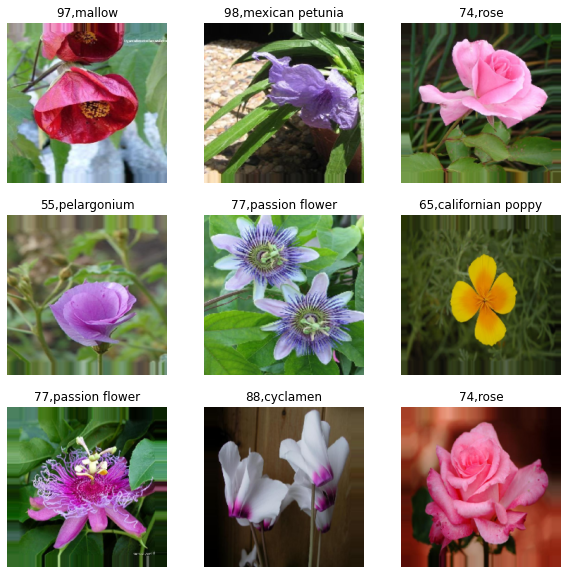

In [189]:
from scipy import ndimage
import scipy.interpolate
datas,labels = train_generator.next()
true_labels=[np.argmax(labels)for labels in labels]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(datas[i])
    plt.title(classes[true_labels[i]]+','+class_names[int(classes[true_labels[i]])])
    plt.axis("off")

In [222]:
'''
ref:经典CNN之：AlexNet介绍
https://blog.csdn.net/daydayup_668819/article/details/79744095

ref:【深度学习理论3】ALexNet模型的详解
https://blog.csdn.net/maweifei/article/details/53117830

ref:batch norm、relu、dropout 等的相对顺序和BN、dropout的几个问题和思考
https://blog.csdn.net/m0_37870649/article/details/82025238
'''
def AlexNet(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(96,(11,11),strides=(4,4),name="conv0")(X_input)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)

    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    X = Dropout(0.5)(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X)
    X = Dropout(0.5)(X)
    
    X = Dense(len(classes),activation='softmax', name = 'softmax')(X)
    model = Model(inputs = X_input, outputs = X, name='AlexNet')
    return model

In [223]:
model=AlexNet((227,227,3))
model.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv0 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_15 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max0 (MaxPooling2D)          (None, 27, 27, 96)        0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 27, 27, 96)        384       
_________________________________________________________________
conv1 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_16 (Activation)   (None, 27, 27, 256)       0   

In [224]:
num_epoch=100

optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.1, nesterov=True, name='SGD')

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(verbose=1, patience=10, min_delta=1e-4, monitor='val_accuracy')
callbacks = [early_stopping]

history=model.fit(train_generator,
                  steps_per_epoch=None,
                  validation_data=validation_generator,
                  validation_steps=None,
                  epochs=num_epoch)
 
print('Training is finished!')

Epoch 1/100
166/166 [==============================] - 114s 688ms/step - loss: 4.6301 - accuracy: 0.0327 - val_loss: 4.5609 - val_accuracy: 0.0355
Epoch 2/100
166/166 [==============================] - 113s 682ms/step - loss: 4.3781 - accuracy: 0.0579 - val_loss: 4.4037 - val_accuracy: 0.0654
Epoch 3/100
166/166 [==============================] - 113s 683ms/step - loss: 4.2138 - accuracy: 0.0759 - val_loss: 4.0864 - val_accuracy: 0.0946
Epoch 4/100
166/166 [==============================] - 113s 681ms/step - loss: 4.0840 - accuracy: 0.0897 - val_loss: 3.9277 - val_accuracy: 0.1111
Epoch 5/100
166/166 [==============================] - 113s 680ms/step - loss: 3.9590 - accuracy: 0.1026 - val_loss: 3.6973 - val_accuracy: 0.1426
Epoch 6/100
166/166 [==============================] - 113s 680ms/step - loss: 3.8548 - accuracy: 0.1098 - val_loss: 3.5977 - val_accuracy: 0.1789
Epoch 7/100
166/166 [==============================] - 114s 689ms/step - loss: 3.7556 - accuracy: 0.1355 - val_loss: 3

In [234]:
model.evaluate(validation_generator)

40/40 [==============================] - 22s 558ms/step - loss: 1.2887 - accuracy: 0.6777


[1.2886584997177124, 0.6776989698410034]

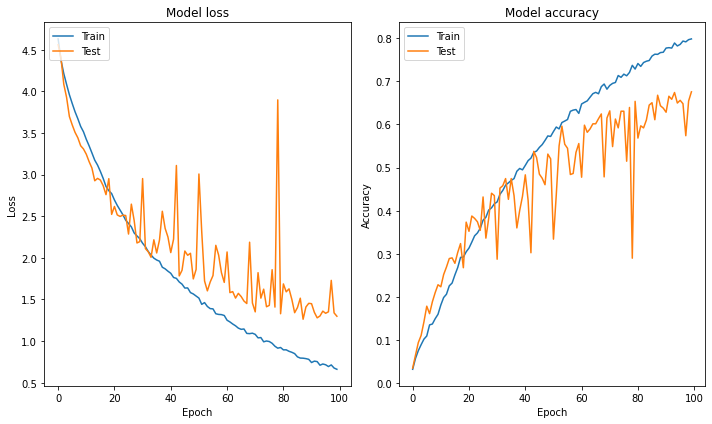

In [225]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,6), ncols=2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss']) 
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')
ax1.set_title(f'Model loss')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')
ax2.set_title(f'Model accuracy')
plt.tight_layout()
plt.savefig(r'C:\Users\user\Desktop\問號問號\fc_alexnet_with_pca_hitroy_lr31.jpg')

In [217]:
'''
model.save('fc_alexnet.h5')
'''
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\user\Desktop\問號問號\fc_alexnet.h5')

10:99.98%
22:0.01%
25:0.00%
92:0.00%
79:0.00%
10


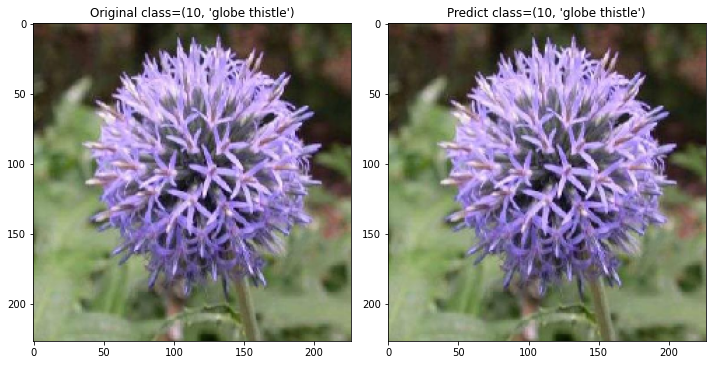

In [228]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
file_path=r'C:\Users\user\chou_paper_data\flower_data\valid'
label_path=r'10'
image_path=r'image_07094.jpg'
orig_image=image.load_img(file_path+'\\'+label_path+'\\'+image_path, target_size=img_size)
test_image=image.img_to_array(orig_image)/255

pred_image = test_image[None]
y = model.predict(pred_image)

for i in np.argsort(y[0])[::-1][:5]:
    print('{}:{:.2f}%'.format(classes[i], y[0][i] * 100))

predict_label=classes[np.argsort(y[0])[::-1][0]]
print(predict_label)
fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(orig_image)
ax1.set_title(f'Original class={int(label_path),class_names[int(label_path)]}')
ax2.imshow(test_image)
ax2.set_title(f'Predict class={int(predict_label),class_names[int(predict_label)]}')
plt.tight_layout()
plt.show()

In [231]:
predict=model.predict(pred_generator,steps=nb_samples)
pred_classes=sorted([o for o in os.listdir(predict_dir)])
y_true=[]
for i in range(nb_samples):
    y_true.append(pred_classes[pred_generator.classes[i]])

y_pred=[]
for j in range(nb_samples):
    predict_label=classes[np.argsort(predict[j])[::-1][0]]
    y_pred.append(predict_label)
    
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7518337408312958

In [229]:
import time
start=time.time()
num=0
acc=0
for root, dirs, files in os.walk(r'C:\Users\User\chou_paper_data\flower_data\valid',topdown=False):
    for name in files:
        orig_image=image.load_img(os.path.join(root,name), target_size=img_size)
        test_image=image.img_to_array(orig_image)/255
        pred_image=test_image[None]
        y=model.predict(pred_image)
        predict_label=classes[np.argsort(y[0])[::-1][0]]

        file=os.path.basename(os.path.dirname(os.path.dirname(root)))
        subfile_l1=os.path.basename(os.path.dirname(root))#train, test, validation
        subfile_l2=os.path.basename(root)#label
 
        fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
        ax1.imshow(orig_image)
        ax1.set_title(f'Original Image{int(subfile_l2), class_names[int(subfile_l2)]}')
        ax2.imshow(test_image)
        ax2.set_title(f'Predict{int(predict_label), class_names[int(predict_label)]}')
        plt.tight_layout()
        
        write_path=os.path.abspath(os.path.join(root, "../.."))+'_predict fc_alexnet'
        
        if subfile_l2==predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_true')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true')
            if os.path.exists(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)

            plt.savefig(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2+'\\'+name)
            acc+=1
        if subfile_l2!=predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_false')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false')
            if os.path.exists(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)
            
            plt.savefig(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2+'\\'+name)
        plt.close()
        num+=1
end=time.time()
print('accuracy=',acc/num)
print(end-start)

accuracy= 0.7518337408312958
249.30420970916748
